In [1]:
# Importation des libraries de base. 

import pandas as pd
import os
import numpy as np
import dask.dataframe as dd 
import warnings 
warnings.filterwarnings("ignore")



In [2]:
# Fichier avec les variables d'intéret : dernière version : 13/02 

df_cct = pd.read_parquet("/home/onyxia/work/df_cct_final.parquet")

In [3]:
# Visualisation du fichier : 

df_cct.head()

User  Card  Month  Day day_of_week  Hours  Amount           Use Chip  \
0     0     0      9    1      Sunday      6  134.09  Swipe Transaction   
1     0     0      9    1      Sunday      6   38.48  Swipe Transaction   
2     0     0      9    2      Monday      6  120.34  Swipe Transaction   
3     0     0      9    2      Monday     17  128.95  Swipe Transaction   
4     0     0      9    3     Tuesday      6  104.71  Swipe Transaction   

         Merchant Name  Merchant City  ... Retired  daily_amount  \
0  3527213246127876953       La Verne  ...       0        134.09   
1  -727612092139916043  Monterey Park  ...       0        172.57   
2  -727612092139916043  Monterey Park  ...       0        120.34   
3  3414527459579106770  Monterey Park  ...       0        249.29   
4  5817218446178736267       La Verne  ...       0        104.71   

   nb_daily_declines_card  bad_pin  insufficient_balance  \
0                     0.0        0                     0   
1                     0.0        0                     0   
2                     0.0        0                     0   
3                     0.0        0                     0   
4                     0.0        0                     0   

   hr_nbt/last_30d_av_hr_nbt  last_18h_nbt  last_18h_amt  last_3d_amt/nbt  \
0                   1.000000           1.0        134.09       134.090000   
1                   1.333333           2.0        172.57        86.285000   
2                   0.750000           1.0        120.34        97.636667   
3                   0.800000           2.0        249.29       105.465000   
4                   0.833333           2.0        233.66       105.314000   

   Is Fraud?  
0          0  
1          0  
2          0  
3          0  
4          0  

[5 rows x 25 columns]

In [4]:
# Nom des colonnes : 

df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'day_of_week', 'Hours', 'Amount',
       'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Zip',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_18h_nbt',
       'last_18h_amt', 'last_3d_amt/nbt', 'Is Fraud?'],
      dtype='object')

In [5]:
# Retirer les variables inutiles : trop corrélées aux autres : 'last_18h_nbt','last_18h_amt'
df_cct =  df_cct.drop(['last_18h_nbt','last_18h_amt'], axis = 1)

In [6]:


df_cct =  df_cct.drop(["Zip"], axis = 1) # inutile : information avec Merchant City (suffisamment précis).

# Drop "User" et "Merchant Name" : Discriment trop les transactions en fonctions des Users et Merchants: 
# on veut 
# une analyse sur les transactions.

df_cct =  df_cct.drop(["User", "Merchant Name"], axis = 1)

In [7]:
# Gérer les variables catégorielles pour DBSCAN. 
# Eviter le problème de hiérarchie entre les modalités : 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?fbclid=IwAR2eCoPI9skUHDegZeP31K--Psh2thHY_5anQPtngWD6qU3caG1UxFdwtR4
# On utilise One Encoder. 
# Package sklearn.preprocessing. 
# On recode sous forme de dummies les modalités intéressantes. 

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Ex : On commence par la variable "Use Chip"     (A faire  "Merchant State", "Merchant City", 'day_of_week' )

# Pour "Use Chip": (on garde toutes les modalités)

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [9]:
# Pour "Merchant State" : (on garde uniquement les 10 modalités les plus fréquentes)


enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Merchant State"]]).toarray()

features_labels = np.array(enc.get_feature_names_out())

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [10]:
# Pour "Merchant City" : (on garde uniquement les 10 modalités les plus fréquentes)

enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Merchant City"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [11]:
# Pour 'day_of_week': (on garde toutes les modalités)

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[['day_of_week']]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [12]:
# On a plus besoin de ces 4 variables catégorielles, on les a retraité. 

df_cct =  df_cct.drop(["Merchant State", "Merchant City", "Use Chip", 'day_of_week'], axis = 1)

# On retire également la variable "Card" : pas d'intérêt pour le clustering
# On souhaite étudier les types de transaction de manière générale. 
df_cct =  df_cct.drop(["Card" ], axis = 1)


In [13]:
# On ne centre réduit pas toutes les variables (perte d'information), on centre réduit unquement "timesstamp". 

#for i in range(len(df_cct.columns)):
    #mean = np.mean(df_cct[df_cct.columns[i]])
    #ec = np.std(df_cct[df_cct.columns[i]])
    #df_cct[df_cct.columns[i]] = (df_cct[df_cct.columns[i]]-mean)/ec

#mean = np.mean(df_cct[df_cct.columns["timestamp"]])
#ec = np.std(df_cct[df_cct.columns["timestamp"]])
#df_cct[df_cct.columns["timestamp"]] = (df_cct[df_cct.columns["timestamp"]]-mean)/ec


# Ici, on a pas besoin de centrer réduire les variables : 

# df_cct.head()

In [14]:
# Nom des colonnes : 

df_cct.columns

Index(['Month', 'Day', 'Hours', 'Amount', 'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'Retired', 'daily_amount', 'nb_daily_declines_card',
       'bad_pin', 'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'last_3d_amt/nbt', 'Is Fraud?', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'Merchant State_CA',
       'Merchant State_FL', 'Merchant State_IL', 'Merchant State_NC',
       'Merchant State_NY', 'Merchant State_OH', 'Merchant State_PA',
       'Merchant State_TX', 'Merchant State_None',
       'Merchant State_infrequent_sklearn', 'Merchant City_Brooklyn',
       'Merchant City_Chicago', 'Merchant City_Dallas',
       'Merchant City_Houston', 'Merchant City_Indianapolis',
       'Merchant City_Los Angeles', 'Merchant City_Miami',
       'Merchant City_ONLINE', 'Merchant City_Orlando',
       'Merchant City_infrequent_sklearn', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [15]:
#Est ce que il y a des nan ? 
#print(df_cct.isna().all())

# Non, tout est ok

In [16]:
# Importation des libraries pour l'ACP et DBSCAN. 

import pandas.util.testing as tm
import seaborn as sns
from sklearn import cluster 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from collections import Counter

In [17]:
# Problème de puissance de calcul on fait DBSCAN seulement sur 200 000 transactions tirées aléatoirement. 
# Sinon le Kernel meurt.... 

# Important : Nouvelle idée : => surreprésenter les frauds pour pouvoir interpréter quelque chose. 
# On va prendre 5 % de fraud : 10000 sur l'échantillon de 200000 
#df_cct = df_cct1
df_cct1 = df_cct.copy()

# Fraud : 
df_cct_fraud = df_cct[df_cct['Is Fraud?'] == 1 ]
df_cct_non_fraud = df_cct[df_cct['Is Fraud?'] == 0 ]

#len(df_cct_fraud)
ech1 = df_cct_fraud.sample(10000)
ech2 = df_cct_non_fraud.sample(190000)


df_cct =  pd.concat([ech1, ech2], axis = 0)
df_cct = df_cct.sample(200000)
 



In [18]:
df_cct.head()

Month  Day  Hours  Amount  delta_t_s  delta_t_s_card  \
7703073       5   12     19   17.77      12720           12720   
14279080      1   26     17    1.62      11340           11340   
8395243       2   10      7   52.00      62400           62400   
20118621      1   24     17   80.00      37200           37200   
13067888      1   22      7   75.00        180             180   

          amt/daily_income  Retired  daily_amount  nb_daily_declines_card  \
7703073           0.062858        0         93.68                     0.0   
14279080          0.414656        0         27.17                     0.0   
8395243           0.276013        0         52.00                     0.0   
20118621          0.519915        0        233.32                     0.0   
13067888          0.731522        0        203.06                     0.0   

          ...  Merchant City_ONLINE  Merchant City_Orlando  \
7703073   ...                   0.0                    0.0   
14279080  ...                   0.0                    0.0   
8395243   ...                   0.0                    0.0   
20118621  ...                   0.0                    0.0   
13067888  ...                   0.0                    0.0   

          Merchant City_infrequent_sklearn  Friday  Monday  Saturday  Sunday  \
7703073                                1.0     1.0     0.0       0.0     0.0   
14279080                               1.0     0.0     0.0       0.0     0.0   
8395243                                1.0     0.0     1.0       0.0     0.0   
20118621                               1.0     1.0     0.0       0.0     0.0   
13067888                               1.0     0.0     0.0       0.0     0.0   

          Thursday  Tuesday  Wednesday  
7703073        0.0      0.0        0.0  
14279080       0.0      0.0        1.0  
8395243        0.0      0.0        0.0  
20118621       0.0      0.0        0.0  
13067888       0.0      0.0        1.0  

[5 rows x 45 columns]

In [19]:
# Implémentation de DBSCAN : 

# Questionnement ? Quelle distance utiliser ? Cosine ou euclidienne ? 

In [20]:
# Cosine vs. Euclidienne : point théorique : 


# Quelle distance utiliser avec DBSCAN ? Cosine vs euclidienne :
# The Euclidean distance corresponds to the L2-norm of a difference between vectors. 
# The cosine similarity is proportional to the dot product of two vectors and 
# inversely proportional to the product of their magnitudes. (angle)
# Vectors with a small Euclidean distance from one another are located in the same region 
# of a vector space. Vectors with a high cosine similarity 
# are located in the same general direction from the origin.
# Cosine : It is thus a judgment of orientation and not magnitude :  
# two vectors with the same orientation have a 
# cosine similarity of 1, two vectors oriented at 90° relative to each other have a 
# similarity of 0, and two vectors diametrically opposed have a similarity of -1, 
# independent of their magnitude.
# While cosine looks at the angle between vectors 
# (thus not taking into regard their weight or magnitude), 
# euclidean distance is similar to using a ruler to actually measure the distance.



In [21]:
# Dans notre cas : on va utiliser la distance euclidienne. 
# Etape de DBSCAN : 

# 1. •	Normaliser les variables de montants et de nombres de transactions uniquement 
# (laisse les dummys comme elles sont)

# 2. •	Supprimer les champs de dates.

# 3. •	Lancer un clustering DBSCAN. 

In [22]:
# 1. •	Normaliser les variables de montants et de nombres de transactions uniquement 
# (laisse les dummys comme elles sont) 

'amt/daily_income', 'daily_amount', 'last_3d_amt/nbt', 'Amount'



df_cct['amt/daily_income'] = (df_cct['amt/daily_income']-np.mean(df_cct['amt/daily_income']))/np.std(df_cct['amt/daily_income'])

df_cct['daily_amount'] = (df_cct['daily_amount']-np.mean(df_cct['daily_amount']))/np.std(df_cct['daily_amount'])

df_cct['last_3d_amt/nbt'] = (df_cct['last_3d_amt/nbt']-np.mean(df_cct['last_3d_amt/nbt']))/np.std(df_cct['last_3d_amt/nbt'])

df_cct['Amount'] = (df_cct['Amount']-np.mean(df_cct['Amount']))/np.std(df_cct['Amount'])


In [23]:
# On va également centrer réduire ces variables : 'delta_t_s', 'delta_t_s_card', 'nb_daily_declines_card'
# 'hr_nbt/last_30d_av_hr_nbt'


df_cct['delta_t_s'] = (df_cct['delta_t_s']-np.mean(df_cct['delta_t_s']))/np.std(df_cct['delta_t_s'])

df_cct['delta_t_s_card'] = (df_cct['delta_t_s_card']-np.mean(df_cct['delta_t_s_card']))/np.std(df_cct['delta_t_s_card'])

df_cct['nb_daily_declines_card'] = (df_cct['nb_daily_declines_card']-np.mean(df_cct['nb_daily_declines_card']))/np.std(df_cct['nb_daily_declines_card'])

df_cct['hr_nbt/last_30d_av_hr_nbt'] = (df_cct['hr_nbt/last_30d_av_hr_nbt']-np.mean(df_cct['hr_nbt/last_30d_av_hr_nbt']))/np.std(df_cct['hr_nbt/last_30d_av_hr_nbt'])

In [24]:
# 2. •	Supprimer les champs de dates.
# 'Month', 'Day', 'Hours' (On concerve les dummies jours de la semaine.)

df_cct =  df_cct.drop(['Month', 'Day', 'Hours'], axis = 1)

In [25]:
# Description des données : 

print(df_cct.describe())

             Amount     delta_t_s  delta_t_s_card  amt/daily_income  \
count  2.000000e+05  2.000000e+05    2.000000e+05      2.000000e+05   
mean   5.279333e-17 -1.231903e-17   -1.469047e-17      1.314504e-18   
std    1.000003e+00  1.000003e+00    1.000003e+00      1.000003e+00   
min   -5.909717e+00 -3.506603e-01   -3.377056e-01     -9.586707e+01   
25%   -4.063106e-01 -3.181607e-01   -3.107089e-01     -1.263883e-02   
50%   -1.698408e-01 -1.881625e-01   -1.827959e-01     -1.240053e-02   
75%    2.295330e-01  1.722872e-01    9.552735e-02     -1.198103e-02   
max    4.000800e+01  2.714986e+02    2.347343e+02      2.916563e+02   

             Retired  daily_amount  nb_daily_declines_card        bad_pin  \
count  200000.000000  2.000000e+05            2.000000e+05  200000.000000   
mean        0.224110 -7.155165e-17            5.684342e-18       0.002795   
std         0.416996  1.000003e+00            1.000003e+00       0.052794   
min         0.000000 -7.802794e-01           -1.9566

In [26]:
# Reformatage des données pour appliquer DBSCAN. 

X = df_cct.values
X.astype(np.float64)

array([[-0.31643263, -0.19407149, -0.26957107, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49089531, -0.2110599 , -0.27696303, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.05334185,  0.41751115, -0.0034606 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.70636163, -0.33441051, -0.33063506, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.27177129,  0.51057807,  0.03703447, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05550238, -0.05668699,  0.12541657, ...,  0.        ,
         0.        ,  0.        ]])

In [27]:
# Maintenant que nous avons notre jeu de données, nous allons chercher à déterminer le ε "optimal"
# et le Min_sample "optimal" (=> intéressant).
# On veut que 90 à 95 % des observations aient au moins 5 voisins dans leur epsilon-voisinage. 
# On veut éviter un trop grand nombre d'outliers. 
# On part sur un min_sample à 5. 

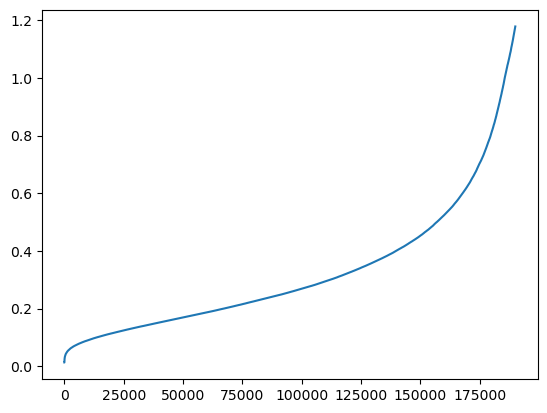

In [28]:
#Scikit-Learn met à disposition une classe NearestNeighbors qui permet de déterminer 
# les voisins les plus proches de chaque observation ainsi que les distances. 

%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:190000,1]
plt.plot(distances);

# Conclusion : prendre eps = 0.8, 0.9, 1, 1.1, 1.2 de tel sorte que au moins 95 % des observations appartiennent à un 
# groupe pour un min_sample = 5. 

# On veut au moins que 90 % des 200 000 transactions soient dans un cluster. 

# => But de ce bout de code : éviter d'avoir trop d'outliers : donne le nombre 
# de points qui sont dans un cluster. 

In [41]:
# Choix de eps et min_samples :

# Choix de eps : 

# Aurre possibilité pour choisir eps : 

#Eps=np.linspace(1,2.5,num=10)
#N=[]
#L=[]
#for eps in Eps:
  #clustering =  cluster.DBSCAN(eps=eps, min_samples=5)
  #clustering.fit(X)
  #labels = clustering.labels_
  #L.append(labels)
  #n=np.unique(labels)
  #N+=[len(n)]

#sns.lineplot(x=Eps,y=N)


# Nbr d'outliers : 

#for s in L:
    #d = Counter(s)
    #for i in d:
        #print(i, d[i])

<AxesSubplot: >

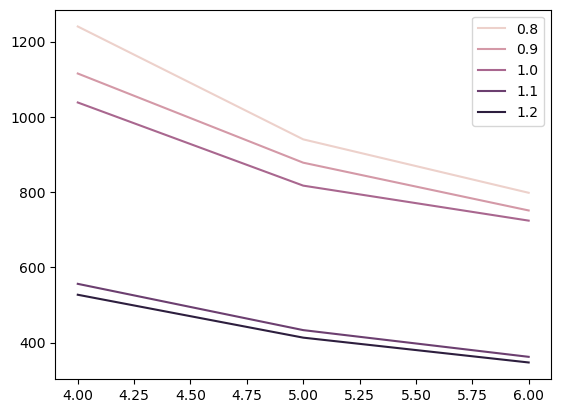

In [29]:
 # Choix de min_samples : On test des eps autour de 0.8, 0.9, 1, 1.1, 1.2 avec des min_sample = 4 ou 5 ou 6. 

Eps = [0.8, 0.9, 1, 1.1, 1.2]
Sample = [4,5,6]
N=[]

x = []
hue = []

for sample in Sample:
  for eps in Eps:
    clustering=cluster.DBSCAN(eps, min_samples=sample, n_jobs = -1)
    clustering.fit(X)
    labels=clustering.labels_
    n=np.unique(labels)
    N+=[len(n)]

    x.append(eps) 
    hue.append(sample)

sns.lineplot(x= hue,y=N, hue = x)

# On affiche le nombre de groupes créés : 

In [50]:
# Choix intéressant pour eps et min_samples :  0.9 et 5

clustering=cluster.DBSCAN(eps=0.9, min_samples=5, n_jobs = -1)
clustering.fit(X)
len(np.unique(clustering.labels_))

# Nombre de groupes : 

878

In [51]:
labels = clustering.labels_
d = Counter(labels)
d[-1]


# Nombre d'outliers pour ce choix de eps et min_sample : 
# Environ 10 %  

25926

In [61]:
# On va faire 2 méthodes de réduction de dimension : ACP et UMAP. 

# On commence par l'ACP. 



# ACP : réduction de dimension => représenter la méthode DBSCAN (nuage de points)
# On utilise les 2 dimensions les plus représentatives du sample (dim 1 et dim 2, les dimensions 
# avec les valeurs propres les plus grandes.) 

pca = PCA()
pca.fit(df_cct)
df_cct.columns = df_cct.columns.astype("str")
df_cct_pca = pca.transform(df_cct)
df_cct_pca_df = pd.DataFrame({
    "Dim1" : df_cct_pca[:,0], 
    "Dim2" : df_cct_pca[:,1]})
df_cct_pca_df["labels"] = clustering.labels_

In [62]:
# Faire apparaître les valeurs propres sur l'ACP.  => Interpréter / comprendre les axes + représentatifs ? 


eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig


Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0       Dim1        1.962428e+00                  18.0                   18.0
1       Dim2        1.533685e+00                  14.0                   33.0
2       Dim3        1.099657e+00                  10.0                   43.0
3       Dim4        9.967310e-01                   9.0                   52.0
4       Dim5        8.438330e-01                   8.0                   60.0
5       Dim6        5.963147e-01                   6.0                   66.0
6       Dim7        5.845022e-01                   5.0                   71.0
7       Dim8        5.412496e-01                   5.0                   76.0
8       Dim9        4.560694e-01                   4.0                   80.0
9      Dim10        3.482786e-01                   3.0                   84.0
10     Dim11        2.295626e-01                   2.0                   86.0
11     Dim12        1.739751e-01                   2.0                   87.0
12     Dim13        1.451548e-01                   1.0                   89.0
13     Dim14        1.440579e-01                   1.0                   90.0
14     Dim15        1.432456e-01                   1.0                   91.0
15     Dim16        1.422988e-01                   1.0                   93.0
16     Dim17        1.416331e-01                   1.0                   94.0
17     Dim18        1.405562e-01                   1.0                   95.0
18     Dim19        9.015510e-02                   1.0                   96.0
19     Dim20        6.652590e-02                   1.0                   97.0
20     Dim21        5.962569e-02                   1.0                   97.0
21     Dim22        4.933008e-02                   0.0                   98.0
22     Dim23        3.996605e-02                   0.0                   98.0
23     Dim24        3.767531e-02                   0.0                   99.0
24     Dim25        3.481858e-02                   0.0                   99.0
25     Dim26        3.174697e-02                   0.0                   99.0
26     Dim27        2.962303e-02                   0.0                  100.0
27     Dim28        7.753724e-03                   0.0                  100.0
28     Dim29        7.622199e-03                   0.0                  100.0
29     Dim30        6.486145e-03                   0.0                  100.0
30     Dim31        6.046097e-03                   0.0                  100.0
31     Dim32        5.128110e-03                   0.0                  100.0
32     Dim33        4.711290e-03                   0.0                  100.0
33     Dim34        4.522670e-03                   0.0                  100.0
34     Dim35        4.328733e-03                   0.0                  100.0
35     Dim36        2.560000e-03                   0.0                  100.0
36     Dim37        3.065649e-04                   0.0                  100.0
37     Dim38        1.283507e-32                   0.0                  100.0
38     Dim39        1.283507e-32                   0.0                  100.0
39     Dim40        1.283507e-32                   0.0                  100.0
40     Dim41        1.283507e-32                   0.0                  100.0
41     Dim42        1.283507e-32                   0.0                  100.0

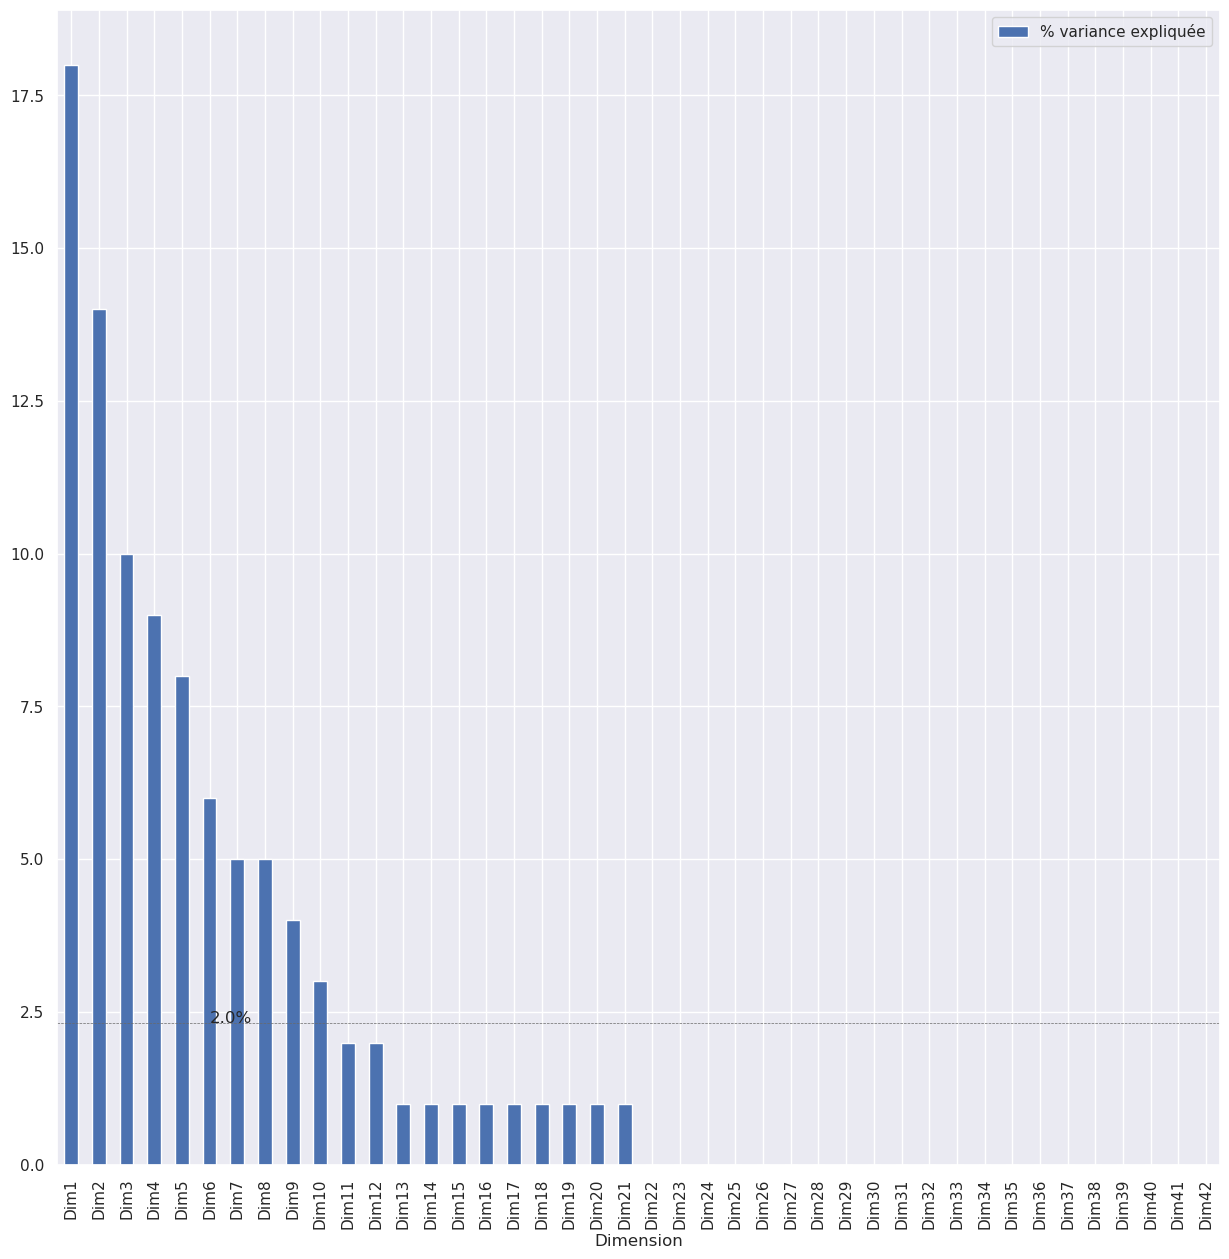

In [63]:
import matplotlib.pyplot as plt

eig.plot.bar(x = "Dimension", y = "% variance expliquée") # permet un diagramme en barres
plt.text(5, 100/(len(pca.explained_variance_)+1), str(np.round(100/(len(pca.explained_variance_)+1)))+"%") # ajout de texte
plt.axhline(y = (100/(len(pca.explained_variance_)+1)), linewidth = .5, color = "dimgray", linestyle = "--") # (100/(len(pca.explained_variance_)+1)) (nb dimensions)
plt.show()


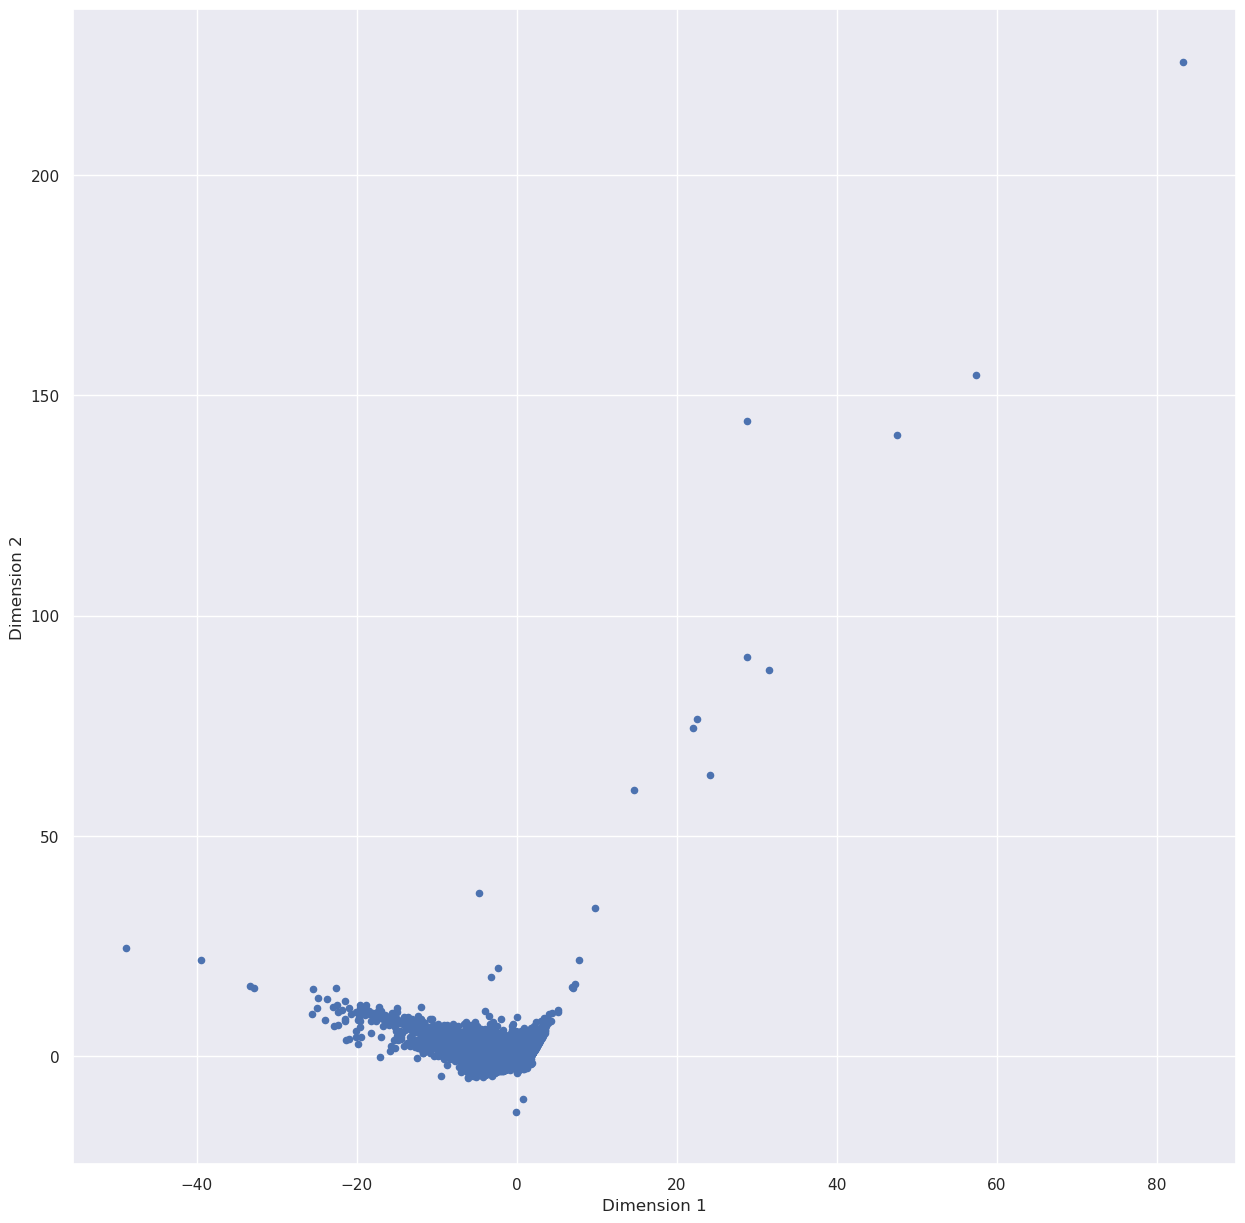

In [64]:
# Représentation de l'ACP :

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
df_cct_pca_df.plot.scatter("Dim1", "Dim2", ax = ax)

# boucle sur chaque pays
# for k in df_cct_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    # if (abs(k[1]['Dim1']) > 5) & (abs(k[1]['Dim2']) > 5):
        # ax.annotate(k[1]["Amount"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

<AxesSubplot: xlabel='Dim1', ylabel='Dim2'>

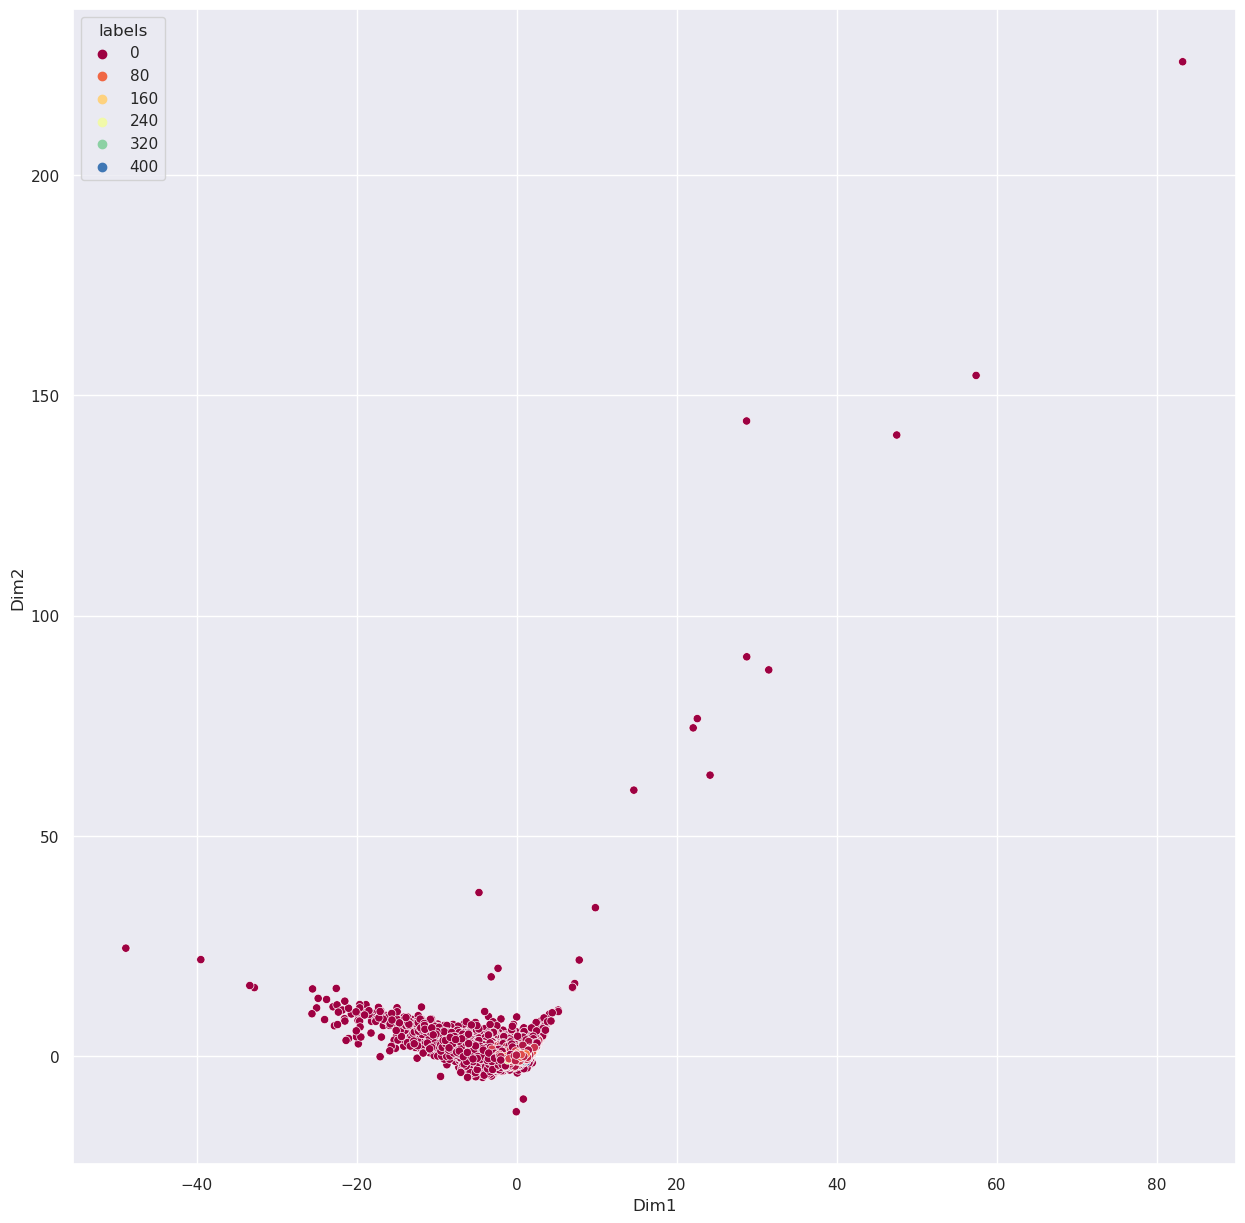

In [36]:
# Représentation de DBSCAN avec l'ACP : 
sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = df_cct_pca_df, x = "Dim1", y = "Dim2", hue = df_cct_pca_df["labels"], palette="Spectral")

In [65]:
# Si le temps : 

#!!!!!!!!!!!!!!!!!!!
# ACP en cascade :........................
#- ACP en cascade : sélectionner 10 familles de variables, faire une ACP sur chaque famille, 
# récupérer les axes, faire une 2e ACP sur toutes les ACP (pour enlever le problème des variables catégorielles)
# Sparse ACP ?
#!!!!!!!!!!!!!!!!!!!

In [66]:
# On passe à la méthode UMAP : 


#!pip install umap-learn

In [67]:
# Un simple !pip install umap et import umap ne fonctionne pas... 
import umap.umap_ as umap

In [41]:
# UMAP : autre méthode de réduction de dimension :

reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_cct.values)

In [52]:
reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

<AxesSubplot: xlabel='A1', ylabel='A2'>

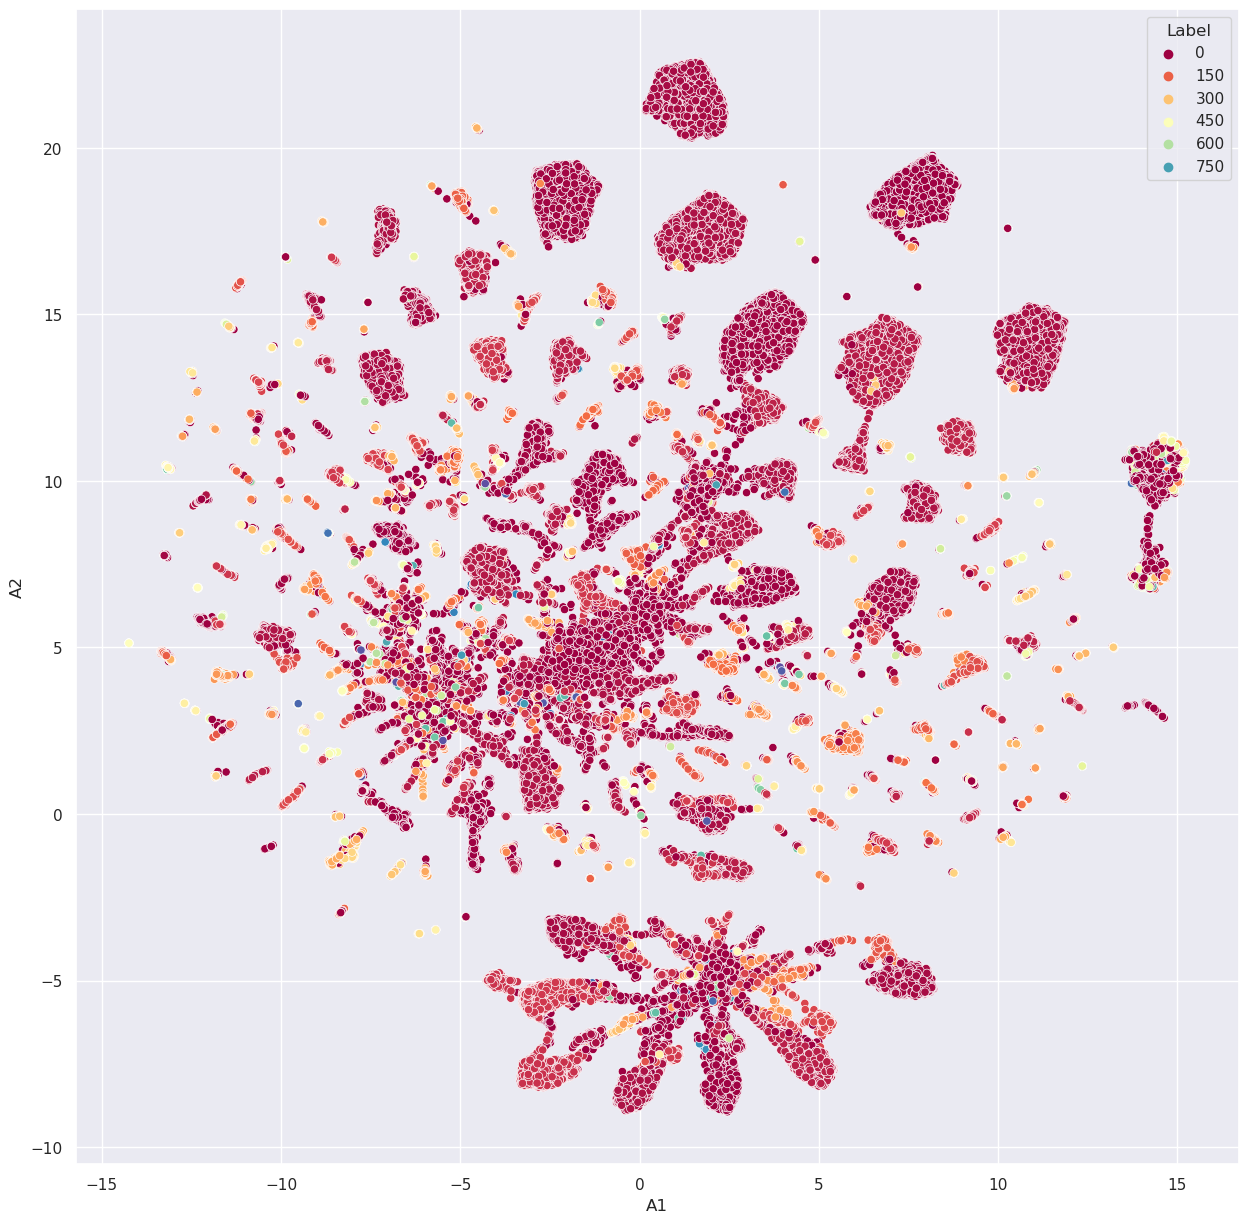

In [53]:
# Représentation de DBSCAN avec UMAP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")

In [54]:
# Interprétation des résultats : On commence par DBSCAN x UMAP : 

# 1. Trouver les points correspondant à des frands : 

# Idée : essayer d'identifier les types de transaction reliés à chaque clusters. 

# Quelle valeur correspond à une transaction en ligne ? 

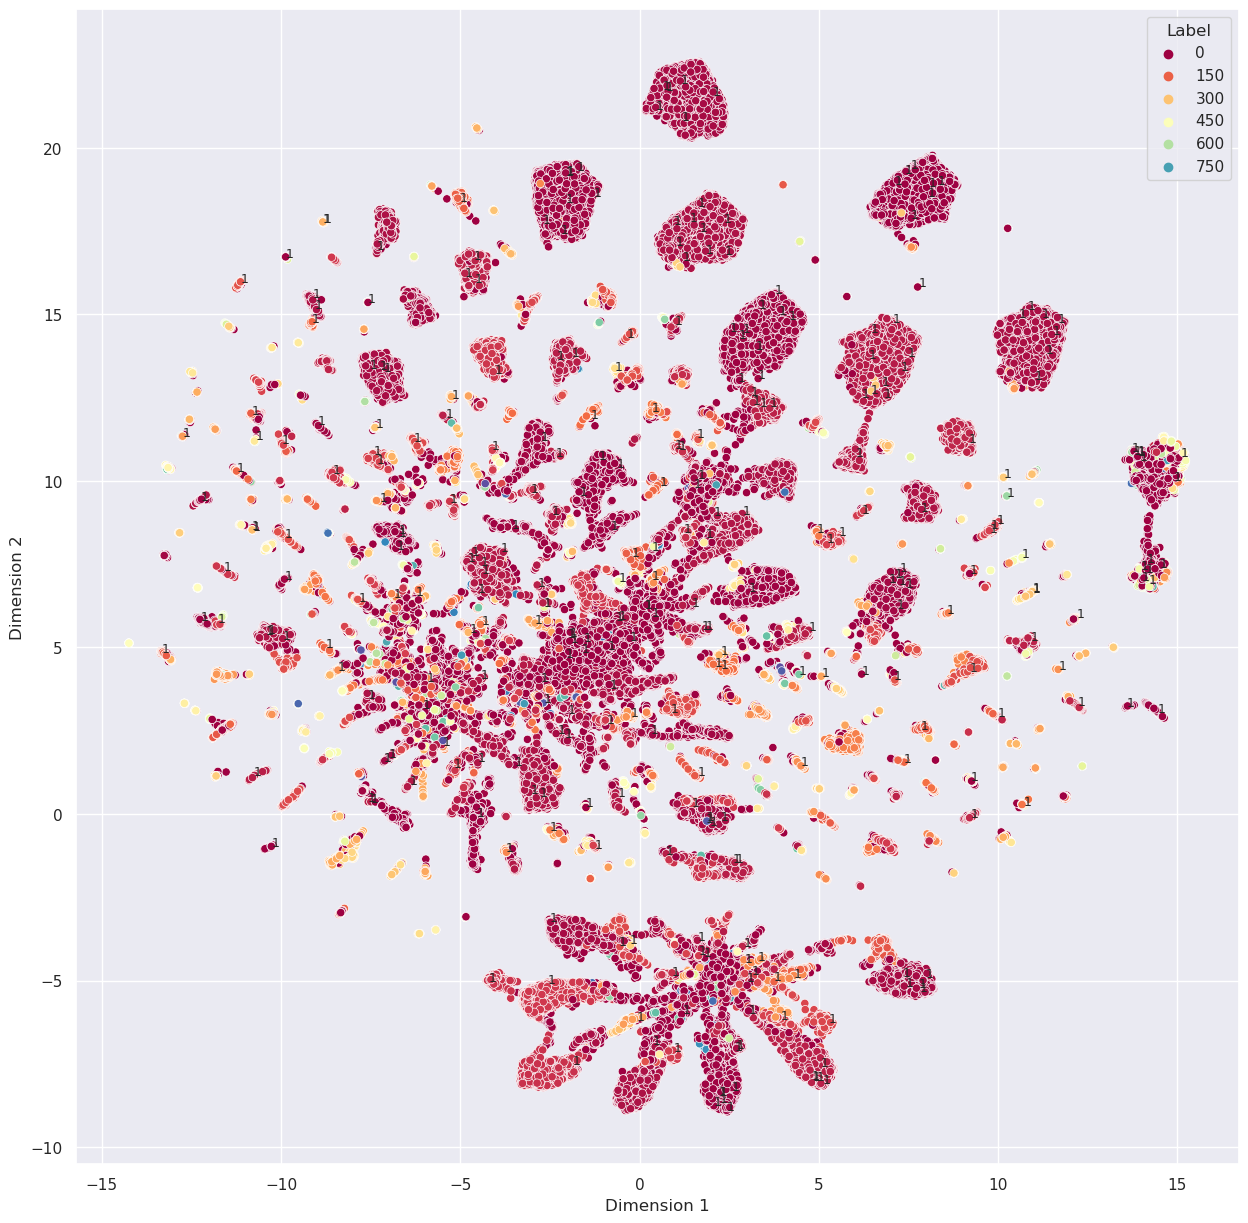

In [55]:
val = df_cct["Online Transaction"].unique()[1]

reduced_dfbis = pd.concat([reduced_df, df_cct["Online Transaction"]], axis = 1)

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

for k in reduced_dfbis.iterrows():
    if (k[1]['Online Transaction'] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()


# Il y en a un peu partout : Tranches : jaune orange 


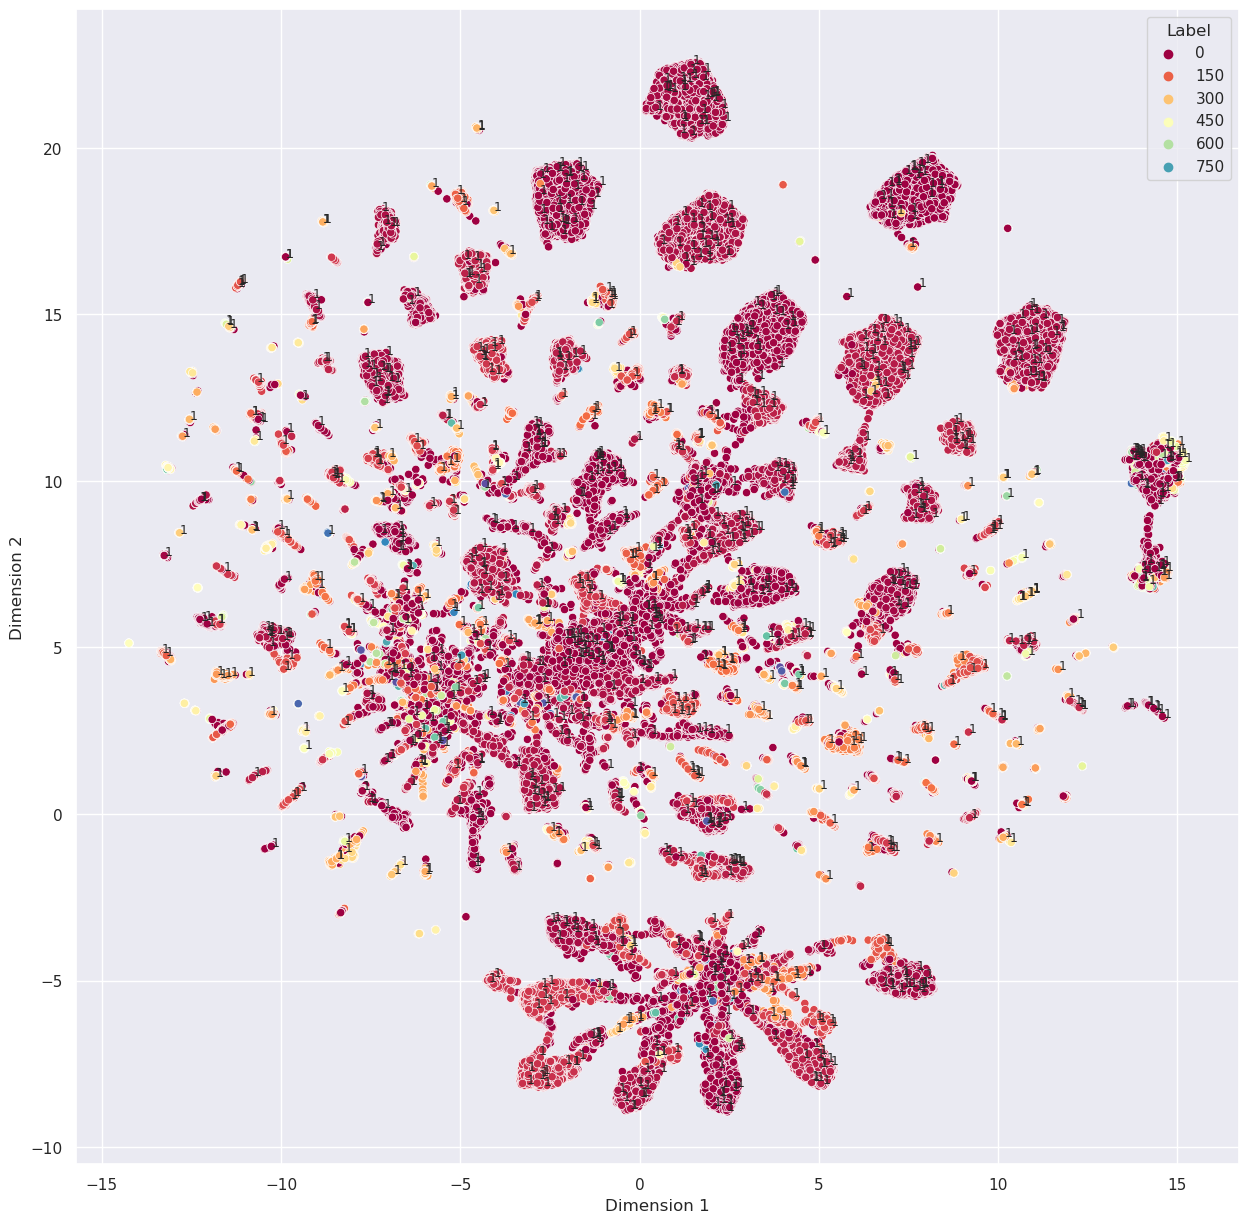

In [56]:
# Essayons pour les autres types de transaction : 

reduced_dfbis = pd.concat([reduced_df, df_cct["Chip Transaction"]], axis = 1)

val = df_cct["Chip Transaction"].unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

for k in reduced_dfbis.iterrows():
    if (k[1]["Chip Transaction"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

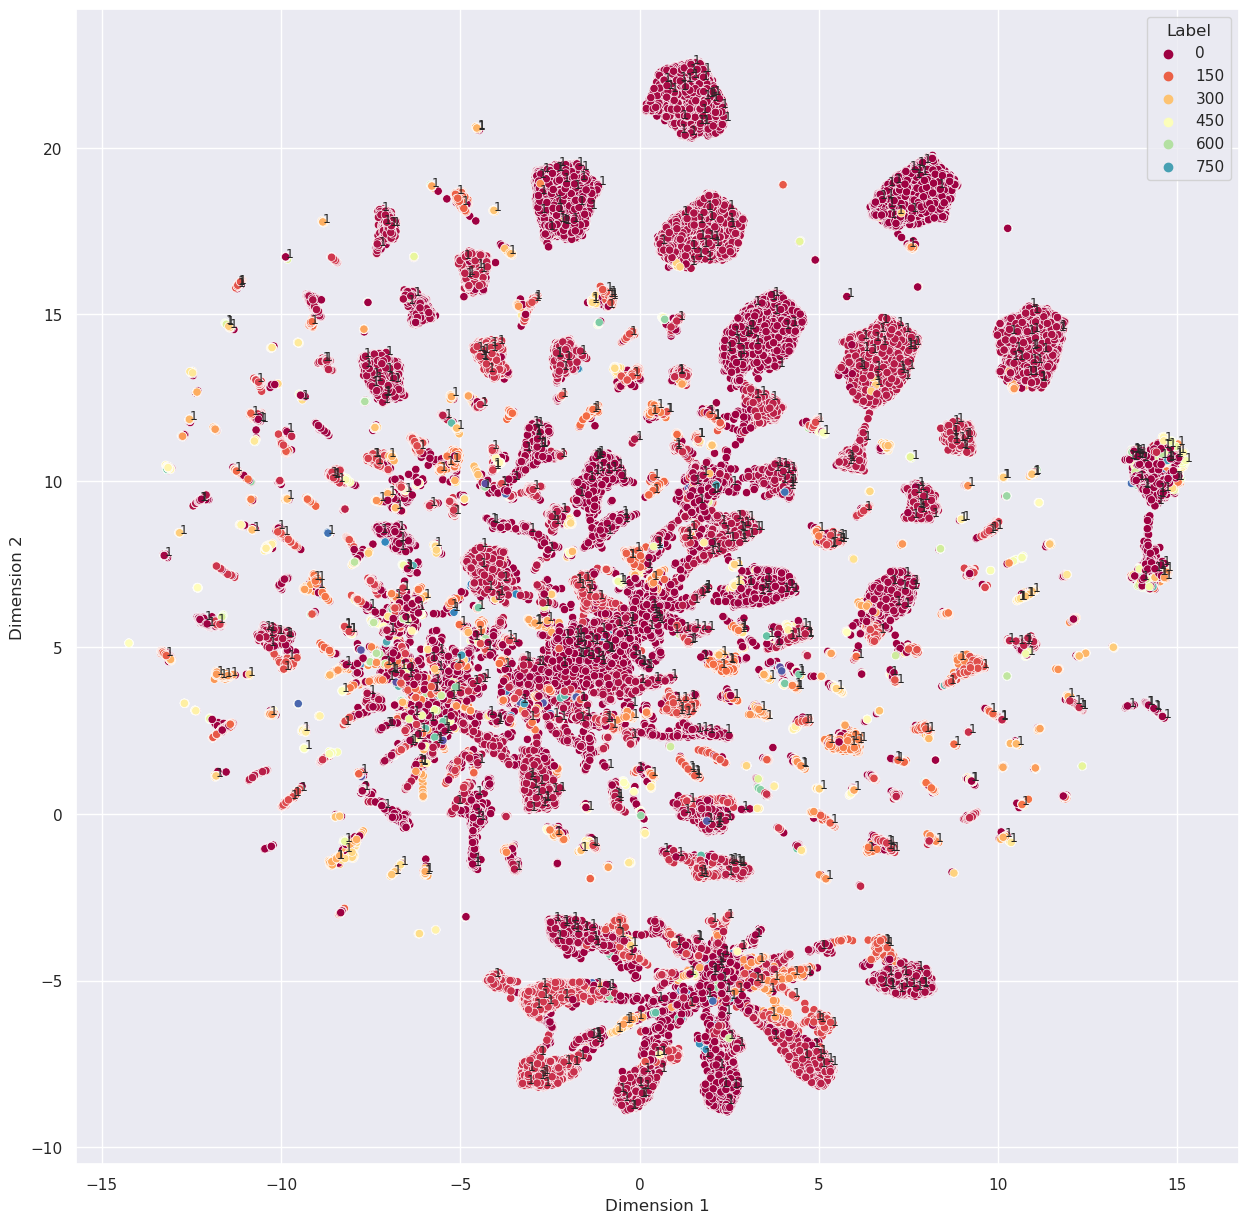

In [57]:
reduced_dfbis = pd.concat([reduced_df, df_cct["Swipe Transaction"]], axis = 1)

val = df_cct["Swipe Transaction"].unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")


for k in reduced_dfbis.iterrows():
    if (k[1]["Swipe Transaction"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

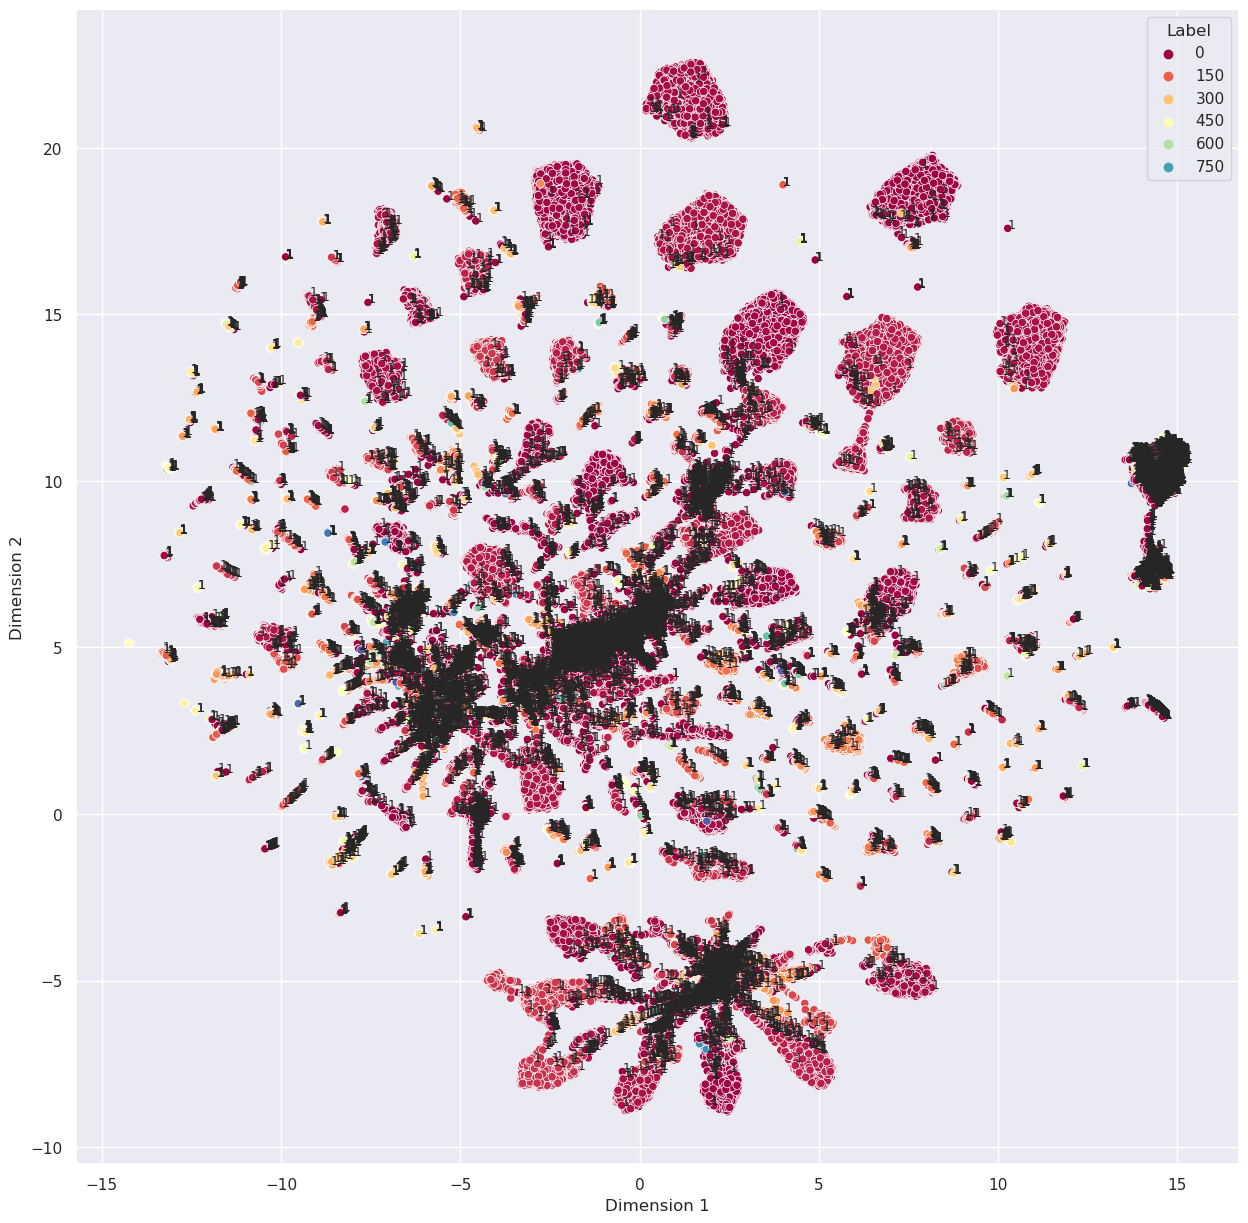

In [58]:
# Trouver les outliers : 

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

for k in reduced_dfbis.iterrows():
    if (k[1]["Label"] == -1) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()


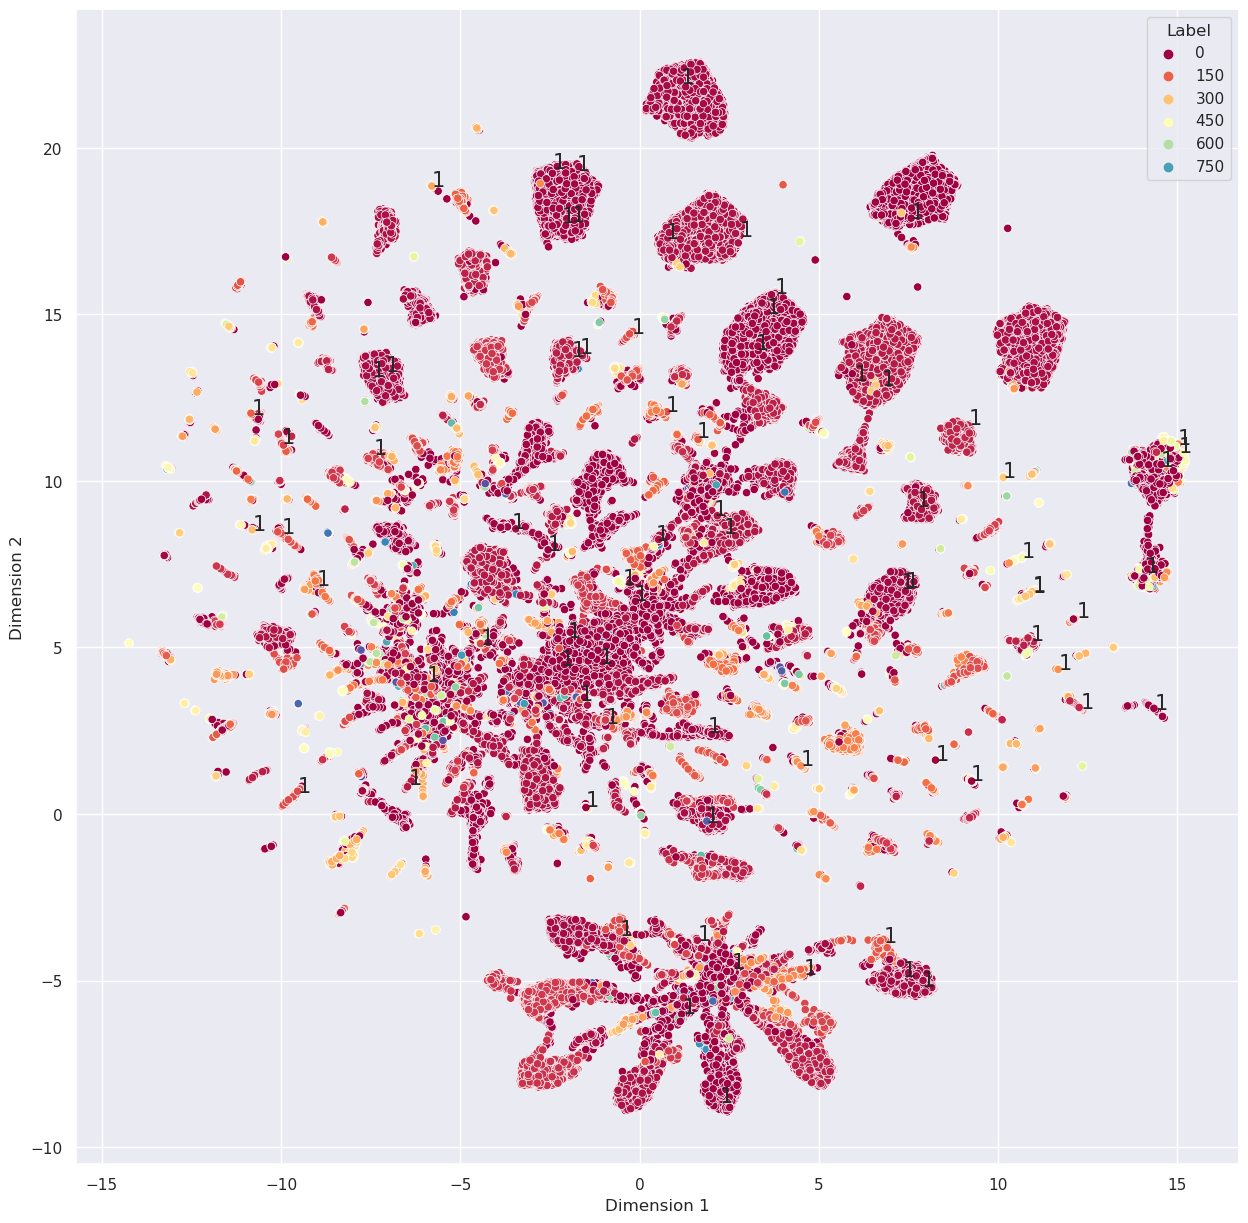

In [59]:
# Trouver les frauds : 
reduced_dfbis = pd.concat([reduced_df, df_cct["Is Fraud?"]], axis = 1)

val = df_cct["Is Fraud?"].unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

for k in reduced_dfbis.iterrows():
    if (k[1]["Is Fraud?"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 15)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

In [60]:
# A faire : 

# 1. Interpréter UMAP => faire UMAP uniquement sur 2 3 variables => essayer d'interpréter les axes. Le faire plusieurs fois. 

# 2. Pour l'ACP (pas passer trop de temps dessus) Regarder matrice de corrélation, les variables corrélé représentent souvent un axe, un paquet. 


In [ ]:
# 1. Interpréter UMAP => faire UMAP uniquement sur 2 3 variables => essayer d'interpréter les axes. Le faire plusieurs fois. 


df_sub = df_cct['amt/daily_income', 'daily_amount', 'last_3d_amt/nbt', 'Amount'] 



In [ ]:
# DBSCAN

X = df_sub.values
X.astype(np.float64)

clustering=cluster.DBSCAN(eps=0.9, min_samples=5, n_jobs = -1)
clustering.fit(X)
len(np.unique(clustering.labels_))

In [ ]:
# UMAP

reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_sub.values)

reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

# Représentation de DBSCAN avec UMAP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")
